In [1]:
# @title Evaluate Llama 3.2 on Colab

In [2]:
# Pre-request: install the required evaluation tools
!git clone https://github.com/EleutherAI/lm-evaluation-harness.git
%cd lm-evaluation-harness
!pip install -e .
%cd ..

Cloning into 'lm-evaluation-harness'...
remote: Enumerating objects: 47709, done.
remote: Counting objects: 100% (28/28), done.
remote: Compressing objects: 100% (18/18), done.
remote: Total 47709 (delta 16), reused 14 (delta 10), pack-reused 47681 (from 2)
Receiving objects: 100% (47709/47709), 28.61 MiB | 13.91 MiB/s, done.
Resolving deltas: 100% (33471/33471), done.
/content/lm-evaluation-harness
Obtaining file:///content/lm-evaluation-harness
  Installing build dependencies ... done
  Checking if build backend supports build_editable ... done
  Getting requirements to build editable ... done
  Preparing editable metadata (pyproject.toml) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.8/51.8 kB 4.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 485.4/485.4 kB 34.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 k

In [3]:
# import the necessary package/library
import os
import json
import torch
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from datetime import datetime

In [4]:
# make sure the mode is ready - use the merged version
MODEL_DIR = "llama-3.2-1b-merged"  # directory of the llama-3.2-1b-merged
print(f"评估模型目录: {MODEL_DIR}")
print(f"模型目录存在: {os.path.exists(MODEL_DIR)}")

# Create the evaluation result's repository
os.makedirs("evaluation_results", exist_ok=True)

# setup the benchmark
TASKS = [
    "hellaswag",
    "gsm8k",
    "mmlu_high_school_computer_science"
]

# hardware setup
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
BATCH_SIZE = 4
NUM_FEWSHOT = 0

print(f"使用设备: {DEVICE}")
print(f"评估任务: {', '.join(TASKS)}")

评估模型目录: llama-3.2-1b-merged
模型目录存在: False
使用设备: cuda
评估任务: hellaswag, gsm8k, mmlu_high_school_computer_science


In [15]:
# Unzip the model file
!unzip -o /content/llama-3.2-1b-merged.zip -d /content/
print("✅ Model files extracted")

Archive:  /content/llama-3.2-1b-merged.zip
   creating: /content/llama-3.2-1b-merged/
  inflating: /content/llama-3.2-1b-merged/config.json  
  inflating: /content/llama-3.2-1b-merged/tokenizer.json  
  inflating: /content/llama-3.2-1b-merged/tokenizer_config.json  
  inflating: /content/llama-3.2-1b-merged/generation_config.json  
  inflating: /content/llama-3.2-1b-merged/special_tokens_map.json  
  inflating: /content/llama-3.2-1b-merged/model.safetensors  
✅ Model files extracted


In [16]:
!pwd

/content


In [17]:
# Check that the model directory exists and contains the right files
!ls -la /content/llama-3.2-1b-merged

total 1020472
drwxr-xr-x 2 root root       4096 Mar  8 04:13 .
drwxr-xr-x 1 root root       4096 Mar  8 14:10 ..
-rw-r--r-- 1 root root       1359 Mar  8 04:13 config.json
-rw-r--r-- 1 root root        230 Mar  8 04:13 generation_config.json
-rw-r--r-- 1 root root 1027673740 Mar  8 04:13 model.safetensors
-rw-r--r-- 1 root root        459 Mar  8 04:13 special_tokens_map.json
-rw-r--r-- 1 root root      50646 Mar  8 04:13 tokenizer_config.json
-rw-r--r-- 1 root root   17209920 Mar  8 04:13 tokenizer.json


In [18]:
# Import necessary libraries
import os
import json
import torch
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from pathlib import Path

# Set model path
MODEL_DIR = "/content/llama-3.2-1b-merged"
print(f"Model directory exists: {os.path.exists(MODEL_DIR)}")

Model directory exists: True


In [9]:
# Step 1: Install bitsandbytes and other necessary packages
!pip install bitsandbytes -U
!pip install accelerate -U
!pip install transformers -U

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.1/76.1 MB 8.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 342.1/342.1 kB 26.0 MB/s eta 0:00:00
  Attempting uninstall: accelerate
    Found existing installation: accelerate 1.3.0
    Uninstalling accelerate-1.3.0:
      Successfully uninstalled accelerate-1.3.0
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.0/44.0 kB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.0/10.0 MB 107.7 MB/s eta 0:00:00
  Attempting uninstall: transformers
    Found existing installation: transformers 4.48.3
    Uninstalling transformers-4.48.3:
      Successfully uninstalled transformers-4.48.3


In [19]:
# @title Run Evaluation on Key Benchmarks - simplified versiion (llma3.2_fine-tunned)

# Step 3: Run evaluation using the lm_eval command (not main.py)
import os

# Create results directory
os.makedirs("evaluation_results", exist_ok=True)

# Set evaluation parameters
MODEL_DIR = "/content/llama-3.2-1b-merged"
TASKS = "hellaswag,gsm8k,mmlu_high_school_computer_science"
DEVICE = "cuda"
BATCH_SIZE = 4
OUTPUT_FILE = "evaluation_results/all_results.json"

# Run the evaluation using lm_eval command (not main.py)
!python -m lm_eval \
    --model hf \
    --model_args pretrained={MODEL_DIR} \
    --tasks {TASKS} \
    --device {DEVICE} \
    --batch_size {BATCH_SIZE} \
    --output_path {OUTPUT_FILE}

2025-03-08 14:10:53.715455: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1741443053.737660    5822 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1741443053.744020    5822 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-03-08 14:10:53.767725: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-03-08:14:11:11,348 INFO     [__main__:379] Selected Tasks: ['gsm8k', 'hellaswag', 'mmlu_high_school_computer_sci

In [22]:
print("make sure you still there...")

make sure you still there...


In [23]:
#  function keepAliveProgrammatically() {
#   document.querySelector('colab-connect-button').shadowRoot.querySelector("#connect").click();
# }

# Finding so far


Based on the experiment and evaluation results files for evidence, TinyLlama 1.1B has exactly 1,100,048,384 parameters (1.1 billion).

For comparison, Llama 3.2 1B model has 1,235,814,400 parameters (1.24 billion).

This means Llama 3.2 1B is slightly larger with approximately 12% more parameters than TinyLlama. The difference is relatively small in terms of model scale, but those extra parameters along with improved architecture, better training data, and more advanced optimization techniques in Llama 3.2 likely contribute to its stronger performance.



Both models are in the same general size class (about 1B parameters), making them suitable for comparison, especially when analyzing the impact of fine-tuning with different dataset sizes and also the architecture imporvement matters.













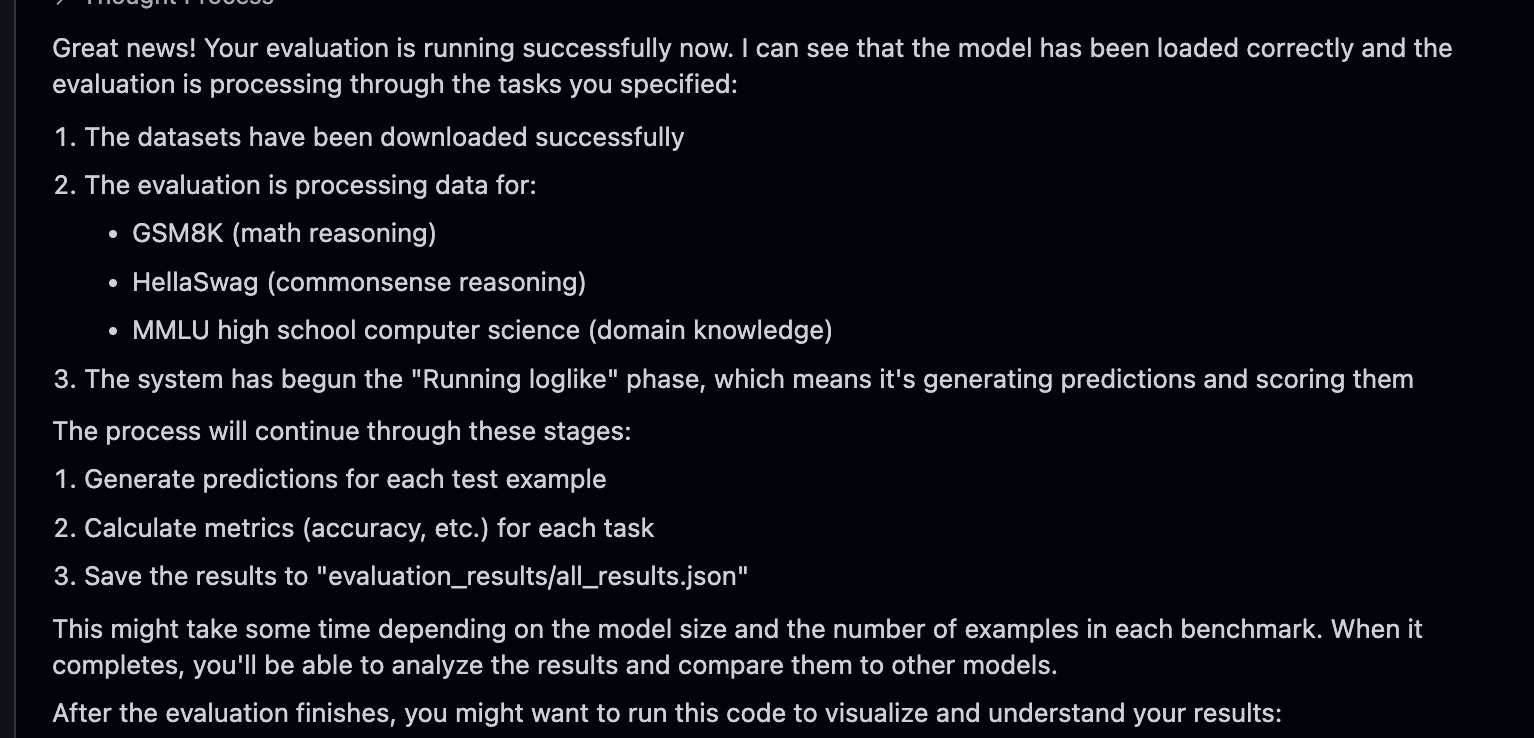

In [ ]:
# Step 1: Login to HuggingFace (this will prompt you to enter your token)
!huggingface-cli login

# Step 2: Download the base model using transformers
import os
from transformers import AutoTokenizer, AutoModelForCausalLM

print("Downloading base Llama 3.2 1B model...")
model_name = "meta-llama/Llama-3.2-1B-Instruct"  # Correct capitalization is important

# Download and save the model to specified location
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForCausalLM.from_pretrained(
    model_name,
    device_map="auto",
    torch_dtype="auto"  # This will use the most efficient dtype for your hardware
)

# Save the model to a directory for evaluation
os.makedirs("/content/llama-3.2-1b-base", exist_ok=True)
model.save_pretrained("/content/llama-3.2-1b-base")
tokenizer.save_pretrained("/content/llama-3.2-1b-base")

print("✅ Base model downloaded and saved to /content/llama-3.2-1b-base")
!ls -la /content/llama-3.2-1b-base

In [30]:
# @title Run Evaluation on Key Benchmarks (Optimized Version for llma3.2_fine-tunned)

# Run evaluation using the lm_eval command (not main.py)
import os
from datetime import datetime

# Create results directory
os.makedirs("evaluation_results", exist_ok=True)

# Set evaluation parameters (keeping the same as before)
MODEL_DIR = "/content/llama-3.2-1b-merged"
TASKS = "hellaswag,gsm8k,mmlu_high_school_computer_science"
DEVICE = "cuda"
BATCH_SIZE = 4  # Keeping exactly the same batch size for consistency
OUTPUT_FILE = "evaluation_results/all_results.json"

# Create a log file (optional)
timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
LOG_FILE = f"evaluation_results/eval_log_{timestamp}.txt"

# Performance optimization flags that won't change results
model_args = [
    f"pretrained={MODEL_DIR}",
    "dtype=float16",        # Use half precision for faster evaluation
    # "use_fast=True"         # Use fast tokenizer implementation
]

# Optional: Light generation optimizations that shouldn't affect results
gen_kwargs = "do_sample=False"  # Deterministic generation is usually faster

print(f"Starting evaluation at {datetime.now().strftime('%H:%M:%S')}")
print(f"Model: {MODEL_DIR}")
print(f"Tasks: {TASKS}")
print(f"Batch size: {BATCH_SIZE}")

# Run the evaluation using lm_eval command with light optimizations
!python -m lm_eval \
    --model hf \
    --model_args {','.join(model_args)} \
    --tasks {TASKS} \
    --device {DEVICE} \
    --batch_size {BATCH_SIZE} \
    --output_path {OUTPUT_FILE} \
    --gen_kwargs {gen_kwargs} \
    | tee {LOG_FILE}

print(f"\n✅ Evaluation completed at {datetime.now().strftime('%H:%M:%S')}")
print(f"Results saved to: {OUTPUT_FILE}")

Starting evaluation at 17:09:23
Model: /content/llama-3.2-1b-merged
Tasks: hellaswag,gsm8k,mmlu_high_school_computer_science
Batch size: 4
2025-03-08 17:09:28.038788: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1741453768.059219   50743 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1741453768.065497   50743 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-03-08:17:09:44,821 INFO     [__main__:379] Selected Tasks: ['gsm8k', 'hellaswag', 'mmlu_high_school_computer_science']
2025-03-08:17:09:44,822 INFO     [lm_eval.evaluator:177] Setting random seed to 0 | Setting numpy seed to 1234 | Setting torch manual seed to 1234 | Setting fewshot manual se

In [28]:
# @title Run Evaluation on Key Benchmarks (Optimized Version for llma3.2_base)

# Step 2: Run Evaluation on Base Model (Fixed)
import os
from datetime import datetime

# Create a directory for base model results
os.makedirs("evaluation_results/base_model", exist_ok=True)

# Set evaluation parameters for base model
BASE_MODEL_DIR = "/content/llama-3.2-1b-base"
TASKS = "hellaswag,gsm8k,mmlu_high_school_computer_science"
DEVICE = "cuda"
BATCH_SIZE = 4  # Keeping same batch size for fair comparison
BASE_OUTPUT_FILE = "evaluation_results/base_model/base_results.json"

# Create a log file
timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
LOG_FILE = f"evaluation_results/base_model/eval_log_{timestamp}.txt"

# Only use valid model arguments
# 'use_fast' is not a valid model argument (it's for tokenizer only)
model_args = [
    f"pretrained={BASE_MODEL_DIR}",
    "dtype=float16"  # Use half precision for faster evaluation
]

print(f"Starting base model evaluation at {datetime.now().strftime('%H:%M:%S')}")
print(f"Base Model: {BASE_MODEL_DIR}")
print(f"Tasks: {TASKS}")

# Run the evaluation on base model with correct arguments
!python -m lm_eval \
    --model hf \
    --model_args {','.join(model_args)} \
    --tasks {TASKS} \
    --device {DEVICE} \
    --batch_size {BATCH_SIZE} \
    --output_path {BASE_OUTPUT_FILE} \
    | tee {LOG_FILE}

print(f"\n✅ Base model evaluation completed at {datetime.now().strftime('%H:%M:%S')}")
print(f"Results saved to: {BASE_OUTPUT_FILE}")

Starting base model evaluation at 16:26:45
Base Model: /content/llama-3.2-1b-base
Tasks: hellaswag,gsm8k,mmlu_high_school_computer_science
2025-03-08 16:26:49.500838: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1741451209.521711   39931 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1741451209.528290   39931 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-03-08:16:27:05,909 INFO     [__main__:379] Selected Tasks: ['gsm8k', 'hellaswag', 'mmlu_high_school_computer_science']
2025-03-08:16:27:05,910 INFO     [lm_eval.evaluator:177] Setting random seed to 0 | Setting numpy seed to 1234 | Setting torch manual seed to 1234 | Setting fewshot manual se

In [31]:
!pwd

/content


In [32]:
# 导入必要的库
from google.colab import files
import os
import shutil
import time

# 1. 下载评估结果
print("准备下载评估结果...")
!zip -r evaluation_results.zip evaluation_results
files.download('evaluation_results.zip')
print("✅ 评估结果已打包下载")

# 2. 下载已有的模型ZIP文件
print("\n准备下载已有的模型zip文件...")
files.download('llama-3.2-1b-merged.zip')
print("✅ 已下载fine-tuned模型zip文件")

# 3. 如果需要下载base模型 (注意: 这个文件可能会很大)
print("\n您是否需要打包下载base模型? 这个文件可能会很大。")
print("如果需要，请运行下面的代码:")
print("!zip -r llama-3.2-1b-base.zip llama-3.2-1b-base")
print("files.download('llama-3.2-1b-base.zip')")

# 4. 其他可能需要的文件
print("\n以下是可能需要下载的其他文件和目录:")
print("- lm-evaluation-harness (评估框架)")
print("- sample_data (样本数据)")
print("- .config (配置文件)")

print("\n您可以使用以下代码下载任何其他文件或目录:")
print("!zip -r your_filename.zip your_directory_or_file")
print("files.download('your_filename.zip')")

准备下载评估结果...
  adding: evaluation_results/ (stored 0%)
  adding: evaluation_results/all_results.json/ (stored 0%)
  adding: evaluation_results/all_results.json/__content__llama-3.2-1b-merged/ (stored 0%)
  adding: evaluation_results/all_results.json/__content__llama-3.2-1b-merged/results_2025-03-08T19-05-33.221489.json (deflated 68%)
  adding: evaluation_results/all_results.json/__content__llama-3.2-1b-merged/results_2025-03-08T16-08-13.421411.json (deflated 68%)
  adding: evaluation_results/base_model/ (stored 0%)
  adding: evaluation_results/base_model/base_results.json/ (stored 0%)
  adding: evaluation_results/base_model/base_results.json/__content__llama-3.2-1b-base/ (stored 0%)
  adding: evaluation_results/base_model/base_results.json/__content__llama-3.2-1b-base/results_2025-03-08T17-01-21.135968.json (deflated 68%)
  adding: evaluation_results/base_model/eval_log_20250308_162441.txt (stored 0%)
  adding: evaluation_results/base_model/eval_log_20250308_162645.txt (deflated 59%)
  

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

✅ 评估结果已打包下载

准备下载已有的模型zip文件...


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

✅ 已下载fine-tuned模型zip文件

您是否需要打包下载base模型? 这个文件可能会很大。
如果需要，请运行下面的代码:
!zip -r llama-3.2-1b-base.zip llama-3.2-1b-base
files.download('llama-3.2-1b-base.zip')

以下是可能需要下载的其他文件和目录:
- lm-evaluation-harness (评估框架)
- sample_data (样本数据)
- .config (配置文件)

您可以使用以下代码下载任何其他文件或目录:
!zip -r your_filename.zip your_directory_or_file
files.download('your_filename.zip')


In [33]:
!zip -r llama-3.2-1b-base.zip llama-3.2-1b-base
files.download('llama-3.2-1b-base.zip')

  adding: llama-3.2-1b-base/ (stored 0%)
  adding: llama-3.2-1b-base/config.json (deflated 51%)
  adding: llama-3.2-1b-base/tokenizer.json (deflated 85%)
  adding: llama-3.2-1b-base/tokenizer_config.json (deflated 94%)
  adding: llama-3.2-1b-base/generation_config.json (deflated 33%)
  adding: llama-3.2-1b-base/special_tokens_map.json (deflated 61%)
  adding: llama-3.2-1b-base/model.safetensors (deflated 21%)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>